[DEV] Would rename: data.csv → 2025-06-02_13-30-33_data.csv
[DEV] Would rename: DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv → 2025-05-29_18-44-09_DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv
📅 Reference date (TODAY) : 03-06-2025


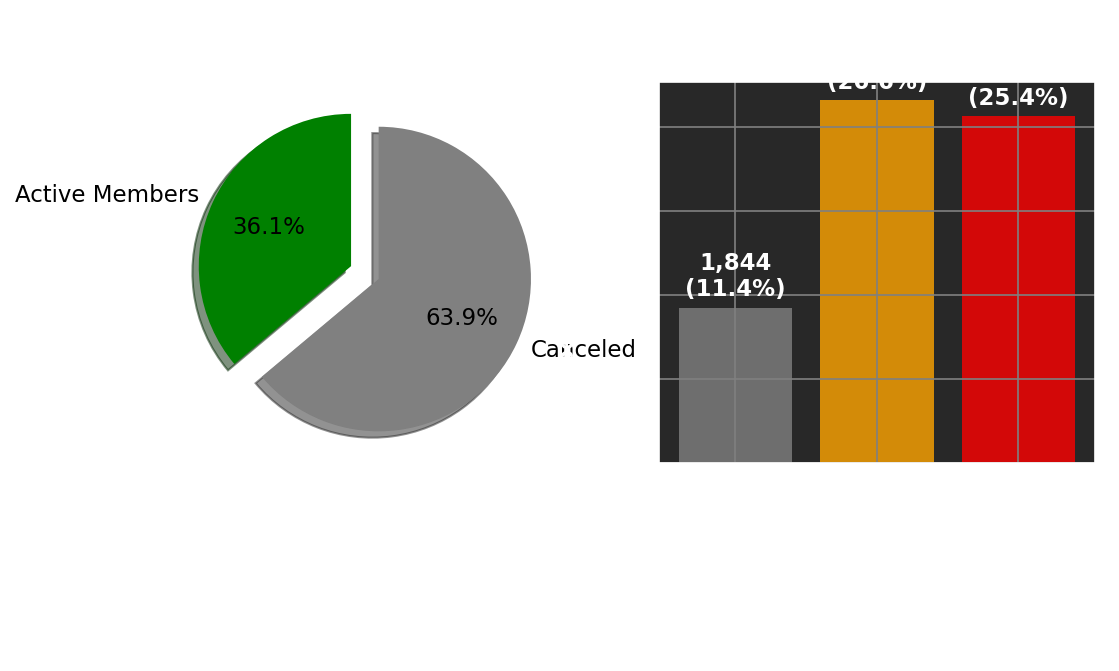



=== MEMBER STATUS BREAKDOWN ===
Total subscription : 16,234

--- Main Distribution ---
├─ Active members: 5,813 (35.8%)
└─ Canceled : 10,288 (63.4%)

--- Cancellation Details ---
├─ Old members: 1,844 (11.4%)
├─ Trial Cancellations: 4,317 (26.6%)
└─ Churn Cancellations: 4,127 (25.4%)




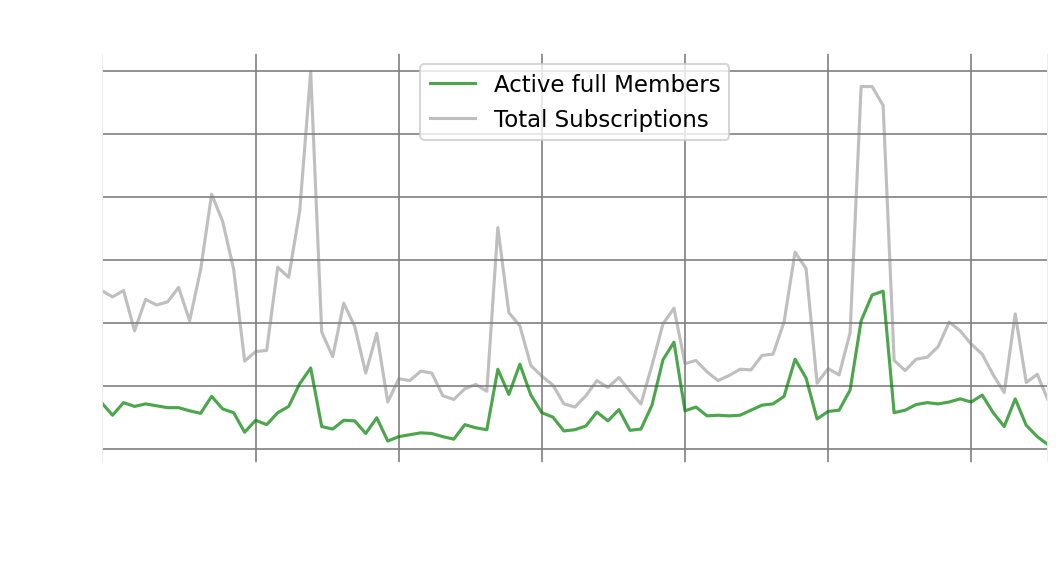

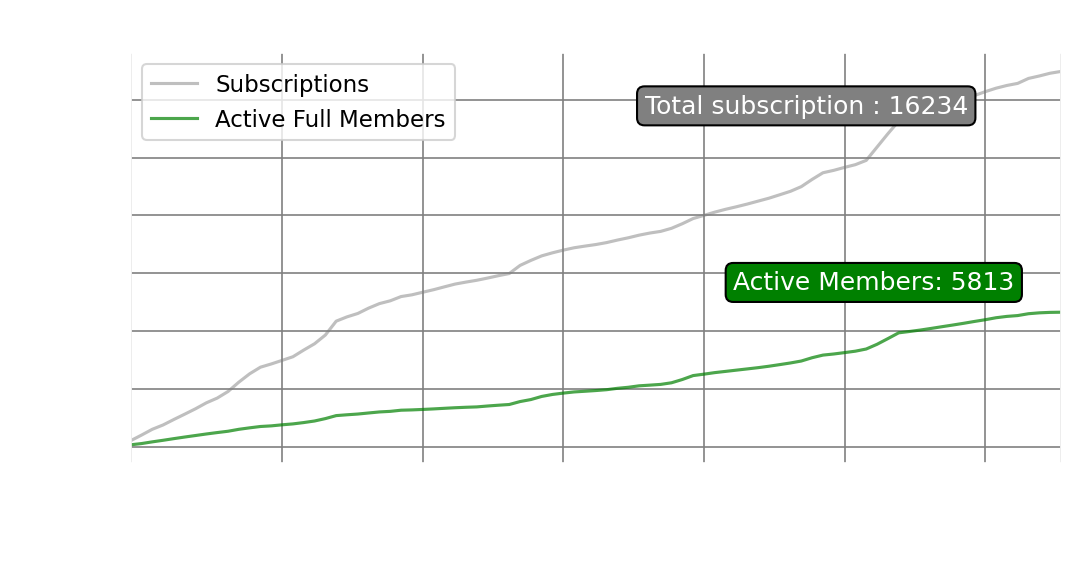




553 Active Gifted Members
5813 Active non-Gifted Members
153 Currently Trialing Members


📅 Last Week Analysis (from 16-05-2025):
New Active Members in the Last Week: 12
New Trialing Members in the Last Week: 107
Still in churn period in the Last Week: 0
Cancel during Trial in the Last Week: 7
Cancel during Churn in the Last Week: 0


📅 Previous Week Analysis (from 09-05-2025 to 16-05-2025):
New Active Members in the Previous Week: 31
New Trialing Members in the Previous Week: 46
Still in churn period in the Previous Week: 15
Cancel during Trial in the Previous Week: 23
Cancel during Churn in the Previous Week: 18


📅 Last 6 Months Analysis (from 24-11-2024):
Mean New Active Members per Week: 198.70
Mean New Trialing Members per Week: 76.50
Mean Still in churn period per Week: 7.50
Mean Cancel during Trial per Week: 49.59
Mean Cancel during Churn per Week: 59.73


In [1]:
# %%

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from datetime import datetime


# %%

# Setting up the plotting style
plt.rcParams.update({'font.size': 11, 'axes.labelsize': 10, 'axes.titlesize': 16})
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['figure.figsize'] = (22, 11)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['legend.title_fontsize'] = 'large'
sns.set_palette("viridis")

# %%

# LOADING CSV
##################
#df_raw = pd.read_csv('~/Documents/_PRO/SIGFRID_DATA/DISHPATCH/data/data.csv')

# Toggle this flag to True in production
RENAME_FILES = False

data_dir = 'data'

# List and sort files by creation time
files = [
    os.path.join(data_dir, f)
    for f in os.listdir(data_dir)
    if os.path.isfile(os.path.join(data_dir, f)) and f.endswith('.csv')
]

sorted_files = sorted(files, key=os.path.getctime, reverse=True)

# Loop over files
for file_path in sorted_files:
    created_at = datetime.fromtimestamp(os.path.getctime(file_path))
    timestamp_str = created_at.strftime('%Y-%m-%d_%H-%M-%S')
    original_name = os.path.basename(file_path)
    new_name = f"{timestamp_str}_{original_name}"
    new_path = os.path.join(data_dir, new_name)

    if RENAME_FILES:
        if not original_name.startswith(timestamp_str):
            os.rename(file_path, new_path)
            print(f"Renamed: {original_name} → {new_name}")
            file_path = new_path
        else:
            print(f"Already renamed: {original_name}")
    else:
        print(f"[DEV] Would rename: {original_name} → {new_name}")


df_raw = pd.read_csv(file_path)

# %%

# DATA PREPROCESSING
##################

def preprocess_data(df):
    """Clean and preprocess the subscription data"""
    df = df_raw.copy()

    # Date conversion
    date_cols = [col for col in df.columns if '(UTC)' in col]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)

    df = df.sort_values(by='Created (UTC)')

    # Column selection and renaming
    columns_to_keep = [
        'Customer Name', 'Status', 'Cancellation Reason',
        'Created (UTC)', 'Start (UTC)', 'Start Date (UTC)', 
        'Current Period Start (UTC)', 'Current Period End (UTC)', 
        'Trial Start (UTC)', 'Trial End (UTC)',
        'Canceled At (UTC)', 'Ended At (UTC)', 
        'senderShopifyCustomerId (metadata)'
    ]
    
    df = df[columns_to_keep]

    df.rename(columns={
        'Customer ID': 'customer_id',
        'Customer Name': 'customer_name',
        'Status': 'status',
        'Cancellation Reason': 'cancellation_reason',
        'Created (UTC)': 'created_utc',
        'Start (UTC)': 'start_utc',
        'Start Date (UTC)': 'start_date_utc',
        'Current Period Start (UTC)': 'current_period_start_utc',
        'Current Period End (UTC)': 'current_period_end_utc',
        'Trial Start (UTC)': 'trial_start_utc',
        'Trial End (UTC)': 'trial_end_utc',
        'Canceled At (UTC)': 'canceled_at_utc',
        'Ended At (UTC)': 'ended_at_utc',
        'senderShopifyCustomerId (metadata)': 'is_gifted_member'
    }, inplace=True)

    # Convert is_gifted_member to boolean
    df['is_gifted_member'] = df['is_gifted_member'].notna() 

    # Reference date for analysis
    reference_date = pd.Timestamp.now(tz='UTC')
    print(f"📅 Reference date (TODAY) : {reference_date.strftime('%d-%m-%Y')}")

    # Consolidate status
    df.loc[df['status'].isin(['past_due', 'incomplete_expired']), 'status'] = 'canceled'

    return df, reference_date

df, reference_date = preprocess_data(df_raw)


# %%


def clean_membership_data(df):
    """Clean and prepare membership data for analysis"""
    # Remove very short subscriptions (likely test accounts)
    df['duration_days'] = (pd.to_datetime(df['ended_at_utc']) - pd.to_datetime(df['created_utc'])).dt.days

    # Keep accounts that are either:
        # 1. Longer than 1 day, OR
    # 2. Still active/trialing (even if recent)
    df_clean = df[~((df['duration_days'] < 1) & ~(df['status'].isin(['active', 'trialing'])))]

    # Remove duplicate signups (within 12 hours)
    df_clean = df_clean.sort_values(['customer_name', 'created_utc'], ascending=[True, False])
    df_clean['time_diff'] = df_clean.groupby('customer_name')['created_utc'].diff()

    # Remove duplicates but keep the most recent (due to descending sort)
    df_clean = df_clean[~((df_clean['time_diff'] < pd.Timedelta(hours=12)) & (df_clean['time_diff'].notna()))]
    df_clean = df_clean.sort_values('created_utc', ascending=True)

    return df_clean.drop(['duration_days', 'time_diff'], axis=1)

df =  clean_membership_data(df)


# %%


# Filter out gifted members and analyze the data

def filter_gifted_members(df):
    """Filter out gifted members from the DataFrame"""
    return df[df['is_gifted_member'] == False].drop(columns=['is_gifted_member'])

df_filtered = filter_gifted_members(df)


def gifted_members(df):
    """Filter  gifted members from the DataFrame"""
    return df[df['is_gifted_member'] == True].drop(columns=['is_gifted_member'])

df_gifted = gifted_members(df)


# %%

# IN CHURN PERIOD
def in_churn_period(df_filtered):
    """Check if a member is in the churn period (14 days after trial end)"""
    # S'assurer que les colonnes sont en format datetime
    df_filtered['in_churn_period'] = (
        (df_filtered['trial_end_utc'] + pd.Timedelta(days=14) > pd.to_datetime(reference_date)) &
        (df_filtered['status'] == 'active')
    )
    return df_filtered

df_filtered = in_churn_period(df_filtered)

# %%

# CANCEL DURING TRIAL PERIOD
def cancel_during_trial(df_filtered):
    """Check if a member canceled during their trial period"""
    # S'assurer que les colonnes sont en format datetime
    df_filtered['canceled_during_trial'] = (
        (df_filtered['canceled_at_utc'].notna()) & 
        (df_filtered['trial_end_utc'] > df_filtered['canceled_at_utc']) 
    )
    return df_filtered

df_filtered = cancel_during_trial(df_filtered) 


# CANCEL DURRING CHURN PERIOD
# if not canceled during trial, check if canceled  during churn period (14days after trial end)
def cancel_during_churn(df_filtered):
    """Check if a member canceled during their churn period (14 days after trial end)"""
    # S'assurer que les colonnes sont en format datetime
    df_filtered['canceled_during_churn'] = (
        (df_filtered['canceled_during_trial'] == False) &
        (df_filtered['trial_end_utc'] + pd.Timedelta(days=14) > df_filtered['canceled_at_utc']) &
        (df_filtered['trial_end_utc'].notna())
    )
    return df_filtered

df_filtered = cancel_during_churn(df_filtered)



# %%



# Plotting the cancelation rates with bar of pie chart
def plot_cancelation_rates(df_filtered):
    """Plot the cancelation rates with bar of pie chart showing percentages"""
    trial_cancellations = df_filtered[df_filtered['canceled_during_trial'] == True]
    churn_cancellations = df_filtered[df_filtered['canceled_during_churn'] == True]
    other_canceled = df_filtered[
        (df_filtered['status'] == 'canceled') & 
        (df_filtered['canceled_during_trial'] == False) & 
        (df_filtered['canceled_during_churn'] == False)
    ] 

    # Calculer les totaux
    total_cancellations = len(trial_cancellations) + len(churn_cancellations) + len(other_canceled)   

    # Active Members
    active_members = df_filtered[df_filtered['status'] == 'active']
    
    
    # Données pour le camembert principal
    main_labels = ['Active Members',  'Canceled']
    main_sizes = [len(active_members), total_cancellations]
    main_colors = ['green', 'grey']
    
    # Données pour le graphique en barres (détail des cancellations)
    detail_labels = ['Old Members', 'Trial Cancellations', 'Churn Cancellations']
    detail_sizes = [len(other_canceled), len(trial_cancellations), len(churn_cancellations)]
    detail_colors = ['grey', 'orange', 'red']
    
    # Créer la figure avec subplots
    fig = plt.figure(figsize=(16, 8))
    
    
    # Subplot 1: Camembert principal
    ax1 = plt.subplot(1, 2, 1)
    wedges, texts, autotexts = ax1.pie(main_sizes, labels=main_labels, colors=main_colors,
                                      autopct='%1.1f%%', shadow=True, startangle=90,
                                      explode=(0.1, 0.1))
    
    # Améliorer l'apparence du texte du camembert
    
    ax1.set_title('Overall Member Distribution', color='white', fontweight='bold', pad=20)
    
    # Subplot 2: Graphique en barres pour le détail des cancellations
    ax2 = plt.subplot(1, 2, 2)
    
    # Calculer les pourcentages par rapport au total
    total = len(df_filtered)
    detail_percentages = [size/total*100 for size in detail_sizes]
    
    bars = ax2.bar(detail_labels, detail_sizes, color=detail_colors, alpha=0.8)
    
    # Ajouter les valeurs et pourcentages sur les barres
    for bar, value, pct in zip(bars, detail_sizes, detail_percentages):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(detail_sizes)*0.02, f'{value:,}\n({pct:.1f}%)', ha='center', va='bottom', color='white', fontweight='bold', fontsize=11)
    
    ax2.set_title('Cancellation Breakdown', color='white', fontweight='bold', pad=20)
    ax2.set_ylabel('Number of Cancellations', color='white', fontweight='bold')
    ax2.set_facecolor('#282828')
    
    # Améliorer l'apparence du graphique en barres
    ax2.tick_params(colors='white')
    for spine in ax2.spines.values():
        spine.set_color('white')
    
    # Rotation des labels x pour une meilleure lisibilité
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Afficher les statistiques détaillées avec pourcentages
    print(f"\n=== MEMBER STATUS BREAKDOWN ===")
    print(f"Total subscription : {total:,}")
    print(f"\n--- Main Distribution ---")
    print(f"├─ Active members: {len(active_members):,} ({len(active_members)/total*100:.1f}%)")
    print(f"└─ Canceled : {total_cancellations:,} ({total_cancellations/total*100:.1f}%)")
    print(f"\n--- Cancellation Details ---")

    print(f"├─ Old members: {len(other_canceled):,} ({len(other_canceled)/total*100:.1f}%)")
    print(f"├─ Trial Cancellations: {len(trial_cancellations):,} ({len(trial_cancellations)/total*100:.1f}%)")
    print(f"└─ Churn Cancellations: {len(churn_cancellations):,} ({len(churn_cancellations)/total*100:.1f}%)")
    print("\n")

plot_cancelation_rates(df_filtered)



# %%



 # Plotting evolution of active members over time
 # Plotting evolution of subscription over time 

def plot_active_members_over_time(df_filtered):
    """Plot the evolution of active members over time"""
    df_filtered.loc[:, 'week'] = df_filtered['created_utc'].dt.tz_localize(None).dt.to_period('W')

    active_counts = df_filtered[df_filtered['status'] == 'active'].groupby('week').size()

    subscription_counts = df_filtered.groupby('week').size()

    plt.figure(figsize=(12, 6))
    active_counts.plot(color='green', alpha=0.7, label='Active full Members')
    subscription_counts.plot(color='grey', alpha=0.5, label='Total Subscriptions')
    
    plt.title('New Active Members Over Time')
    plt.ylabel('Number of Members')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_active_members_over_time(df_filtered)



# %%



# Plotting evolution of active members over time (cumulative)

def plot_cumulative_active_members_over_time(df_filtered):
    """Plot the evolution of active members over time"""
    df_filtered['created_utc'] = pd.to_datetime(df_filtered['created_utc'])
    df_filtered.loc[:, 'week'] = df_filtered['created_utc'].dt.tz_localize(None).dt.to_period('W')

    active_counts = df_filtered[df_filtered['status'] == 'active'].groupby('week').size().cumsum()

    subscription_counts = df_filtered.groupby('week').size().cumsum()


    plt.figure(figsize=(12, 6))

    subscription_counts.plot(color='grey', alpha=0.5, label='Subscriptions')
    active_counts.plot(color='green', alpha=0.7, label='Active Full Members')

    plt.title('Total Active Members Over Time')
    plt.ylabel('Number of Active Members')
    plt.legend()
    # add number of active members at the end of the plot
    plt.annotate(f'Active Members: {active_counts.iloc[-1]}', xy=(0.95, 0.47), xycoords='axes fraction', ha='right', va='top', fontsize=12, color='white',  bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='green'))
    plt.annotate(f'Total subscription : {subscription_counts.iloc[-1]}', xy=(0.90, 0.90), xycoords='axes fraction', ha='right', va='top', fontsize=12, color='white', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='grey'))
 
    plt.tight_layout()
    plt.show()

plot_cumulative_active_members_over_time(df_filtered)


# Creating dataframe for past 5 weeks analysis
def create_past_weeks_dataframe(df_filtered, weeks=5):
    """Create a DataFrame for the last 'weeks' weeks"""
    df_filtered['created_utc'] = pd.to_datetime(df_filtered['created_utc'])
    df_filtered.loc[:, 'week'] = df_filtered['created_utc'].dt.tz_localize(None).dt.to_period('W')
    recent_weeks = df_filtered['week'].unique()[-weeks:]
    df_recent = df_filtered[df_filtered['week'].isin(recent_weeks)]
    return df_recent

df_recent = create_past_weeks_dataframe(df_filtered, weeks=5)



# %%



# Bar plot new active members last 5 weeks
def plot_new_active_members_last_weeks(df_recent, weeks=5):
    """Plot the number of new active members in the last 'weeks' weeks"""
    # Utiliser df_recent au lieu de df_filtered
    df_recent['created_utc'] = pd.to_datetime(df_recent['created_utc'])
    df_recent['week'] = df_recent['created_utc'].dt.to_period('W')
    recent_weeks = df_recent['week'].unique()[-weeks:]
    
    # Utiliser df_recent au lieu de df_filtered
    new_active_counts = df_recent[df_recent['status'].isin(['active', 'canceled'])].groupby('week').size().reindex(recent_weeks, fill_value=0)
    
    new_trialing_counts = df_recent[df_recent['status'] == 'trialing'].groupby('week').size().reindex(recent_weeks, fill_value=0)
    
    plt.figure(figsize=(12, 6))
    
    
    # Créer barres côte à côte
    x = np.arange(len(recent_weeks))
    width = 0.35
    
    plt.bar(x - width/2, new_active_counts.values, width, label='New Active Members', color='green', alpha=0.7)
    plt.bar(x + width/2, new_trialing_counts.values, width, label='New Trialing Members', color='grey', alpha=0.7)
    
    plt.title(f'New Active Members in the Last {weeks} Weeks')
    plt.ylabel('Number of New Members')
    plt.xlabel('Week')
    
    # Afficher les semaines sur l'axe X
    plt.xticks(x, [str(week) for week in recent_weeks], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# %%

print('\n')
print(len(df_gifted[df_gifted['status']== 'active']), 'Active Gifted Members')
print(len(df_filtered[df_filtered['status'] == 'active']), 'Active non-Gifted Members')
print(len(df_filtered[df_filtered['status'] == 'trialing']), 'Currently Trialing Members')

# %%


# LAST WEEK ANALYSIS

def last_week_analysis(df_filtered):
    """Analyze the last week of active members"""
    df_filtered['created_utc'] = pd.to_datetime(df_filtered['created_utc'])
    last_week = df_filtered['created_utc'].max() - pd.Timedelta(days=7)
    
    # Filter for the last week
    df_last_week = df_filtered[df_filtered['created_utc'] >= last_week]
    
    # Count new active members
    new_active_members = df_last_week[df_last_week['status'] == 'active'].shape[0]
    
    # Count new trialing members
    new_trialing_members = df_last_week[df_last_week['status'] == 'trialing'].shape[0]
    
    print("\n")
    print(f"📅 Last Week Analysis (from {last_week.strftime('%d-%m-%Y')}):")
    print(f"New Active Members in the Last Week: {new_active_members}")
    print(f"New Trialing Members in the Last Week: {new_trialing_members}") 
    print(f"Still in churn period in the Last Week: {df_last_week[df_last_week['in_churn_period'] == True].shape[0]}")
    print(f"Cancel during Trial in the Last Week: {df_last_week[df_last_week['canceled_during_trial'] == True].shape[0]}")
    print(f"Cancel during Churn in the Last Week: {df_last_week[df_last_week['canceled_during_churn'] == True].shape[0]}")

last_week_analysis(df_filtered) 

# %%

# PREVIOUS WEEK ANALYSIS 
def previous_week_analysis(df_filtered):
    """Analyze the previous week of active members"""
    df_filtered['created_utc'] = pd.to_datetime(df_filtered['created_utc'])
    last_week = df_filtered['created_utc'].max() - pd.Timedelta(days=7)
    previous_week = last_week - pd.Timedelta(days=7)
    
    # Filter for the previous week
    df_previous_week = df_filtered[(df_filtered['created_utc'] >= previous_week) & (df_filtered['created_utc'] < last_week)]
    
    # Count new active members
    new_active_members = df_previous_week[df_previous_week['status'] == 'active'].shape[0]
    
    # Count new trialing members
    new_trialing_members = df_previous_week[df_previous_week['status'] == 'trialing'].shape[0]
    
    print("\n")
    print(f"📅 Previous Week Analysis (from {previous_week.strftime('%d-%m-%Y')} to {last_week.strftime('%d-%m-%Y')}):")
    print(f"New Active Members in the Previous Week: {new_active_members}")
    print(f"New Trialing Members in the Previous Week: {new_trialing_members}") 
    print(f"Still in churn period in the Previous Week: {df_previous_week[df_previous_week['in_churn_period'] == True].shape[0]}")
    print(f"Cancel during Trial in the Previous Week: {df_previous_week[df_previous_week['canceled_during_trial'] == True].shape[0]}")
    print(f"Cancel during Churn in the Previous Week: {df_previous_week[df_previous_week['canceled_during_churn'] == True].shape[0]}")

previous_week_analysis(df_filtered)


# %%



# LAST 6 MONTHS ANALYSIS (mean by weeks)
def last_6_months_analysis(df_filtered):
    """Analyze the last 6 months of active members"""
    df_filtered['created_utc'] = pd.to_datetime(df_filtered['created_utc'])
    six_months_ago = df_filtered['created_utc'].max() - pd.Timedelta(days=180)
    
    # Filter for the last 6 months
    df_last_6_months = df_filtered[df_filtered['created_utc'] >= six_months_ago]
    
    # Group by week and calculate mean
    df_last_6_months.loc[:, 'week'] = df_last_6_months['created_utc'].dt.tz_localize(None).dt.to_period('W')
    weekly_counts = df_last_6_months.groupby('week').size().reset_index(name='count')
    
    # Calculate mean per week
    mean_per_week = weekly_counts['count'].mean()
    
    print("\n")
    print(f"📅 Last 6 Months Analysis (from {six_months_ago.strftime('%d-%m-%Y')}):")
    print(f"Mean New Active Members per Week: {mean_per_week:.2f}")
    print(f"Mean New Trialing Members per Week: {df_last_6_months[df_last_6_months['status'] == 'trialing'].groupby('week').size().mean():.2f}") 
    print(f"Mean Still in churn period per Week: {df_last_6_months[df_last_6_months['in_churn_period'] == True].groupby('week').size().mean():.2f}")
    print(f"Mean Cancel during Trial per Week: {df_last_6_months[df_last_6_months['canceled_during_trial'] == True].groupby('week').size().mean():.2f}")
    print(f"Mean Cancel during Churn per Week: {df_last_6_months[df_last_6_months['canceled_during_churn'] == True].groupby('week').size().mean():.2f}")

last_6_months_analysis(df_filtered)


# %%